In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import scipy.signal as signal
plt.rcParams.update({'font.size': 15})

from adaptive_filters.LMS import LMS

# Filtering of noisy ECG signals
In this exercise we will use the LMS algorithm for suppressing interference from a signal of interest.
The signal is a measurement of a electrical activity of the heart of a human. This is also known as
an electrocardiogram (ECG). In our case the measurement is contaminated by sinusoidal interference
from the power network

![EKG_problem](img/EKG_problem.png)



## Load noisy data file and find noise frequency

In [2]:
def load_data(path):
    with open(path) as data:
        out = data.readlines()

    return [float(x) for x in out]

In [3]:
path = './ecg.txt'
sample_rate = 500  # Hz
ecg_data = np.array(load_data(path))
ecg_data /= np.max(ecg_data)

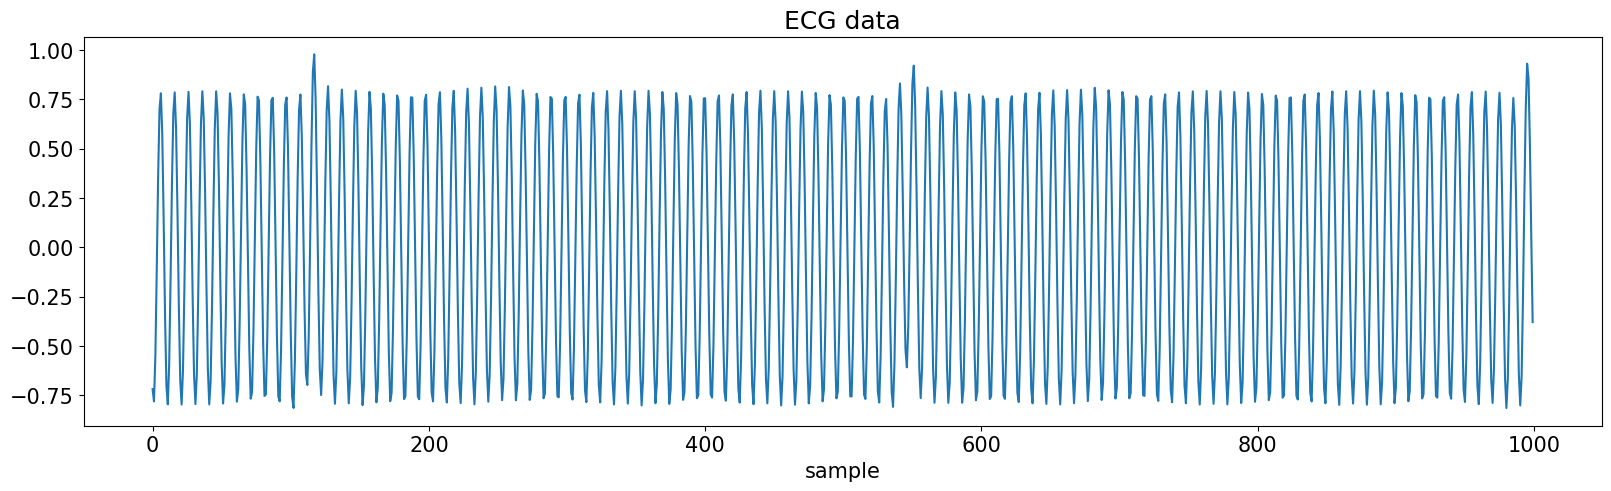

In [4]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:1000])
plt.show()

To remove the power line noise, I use an LMS based algorithm, trying to cancel the noise with a power line frequency signal. To find this noise frequency we estimate the PSD using Bartlett and Welch's method.

In [5]:
_, ecg_spectrum = signal.welch(ecg_data, fs=sample_rate,nperseg=512)
norm_frequencies = np.linspace(0,1,len(ecg_spectrum))  # in units of pi

Assuming a gaussian peak **Later replace with gaussian fit**

In [6]:
peak = np.argmax(ecg_spectrum)

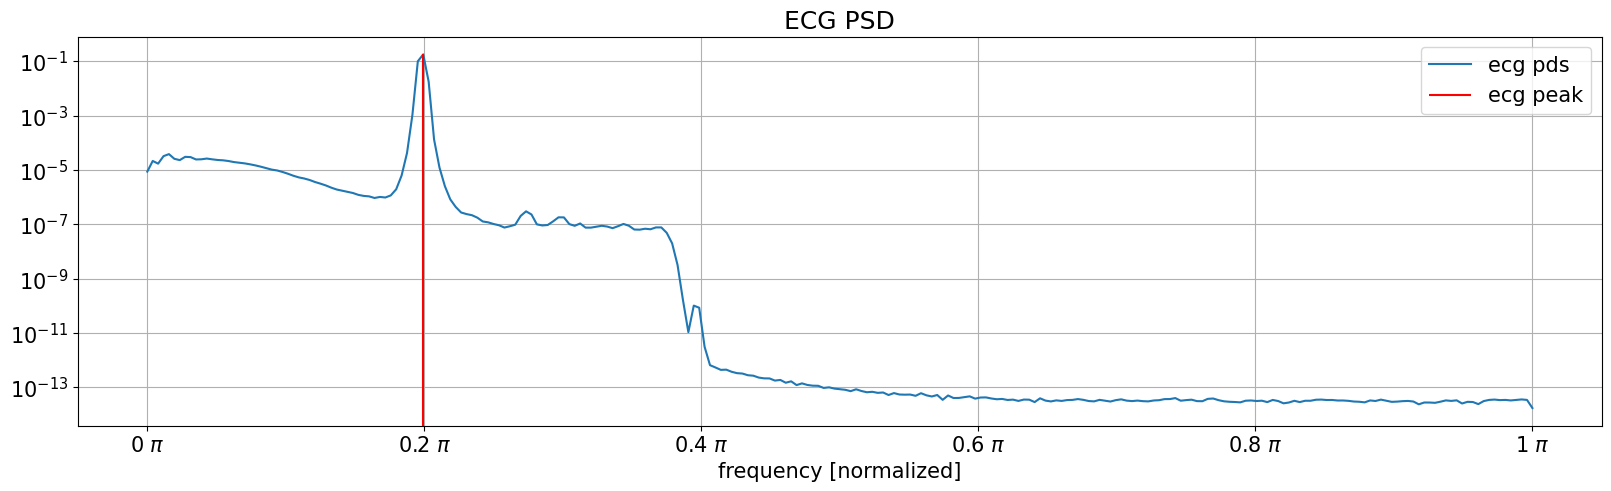

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG PSD')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg pds')
ax.vlines(norm_frequencies[peak], ymin=0, ymax=ecg_spectrum[peak], colors='r', label='ecg peak')
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()

In [8]:
noise_frequency = norm_frequencies[peak]

## Setup adaptive filter

In [9]:
# simulated noise
noise = np.cos(np.pi*np.arange(len(ecg_data))* noise_frequency)  # frequency is in units of pi

Plot as sanity check

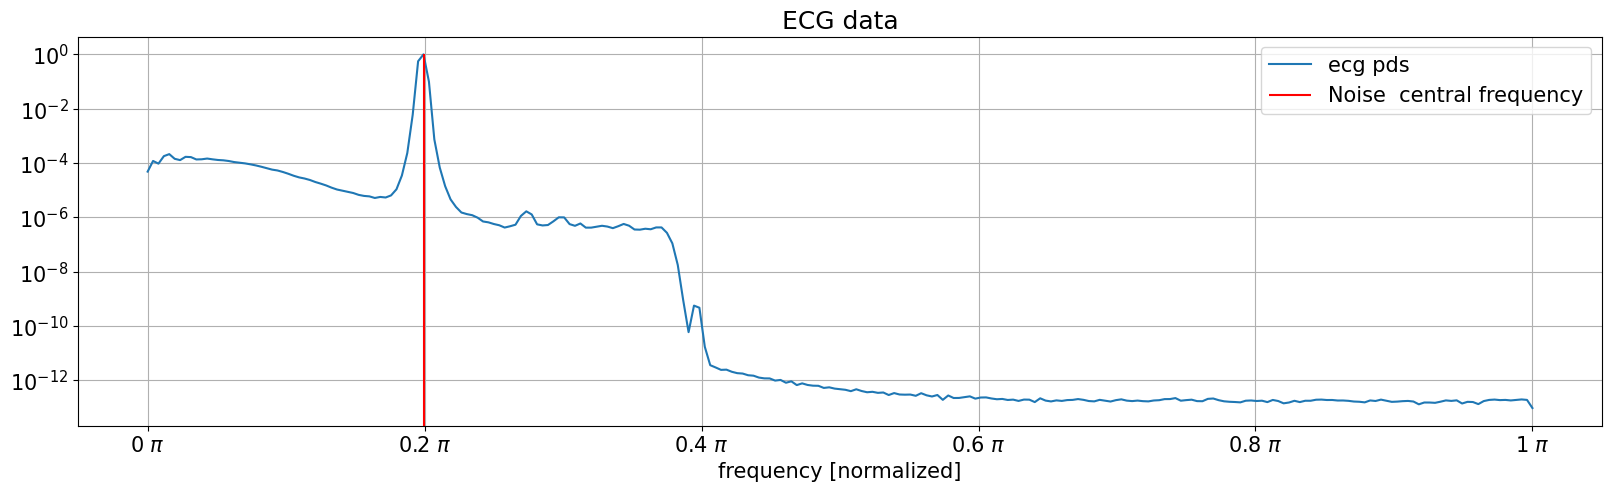

In [10]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG data')
ax.semilogy(norm_frequencies, ecg_spectrum/np.max(ecg_spectrum), label='ecg pds')
ax.vlines(noise_frequency, ymin=0, ymax=1, colors='r', label='Noise  central frequency')
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()


Noise frequency seems ok

# LMS
Finally, we initiate the LMS adaptive filter algorithm

In [23]:
delay = 1  # start with assuming white noise
step_size = 0.0025  # guess small steps
filter_taps = 5  # small filter to start with
weights = np.zeros(filter_taps)

lms = LMS(signal=noise, desired_signal=ecg_data, weights=weights, step_size=step_size)

In [24]:
lms.adapt_weights()
weights = lms.weights[:,-1]

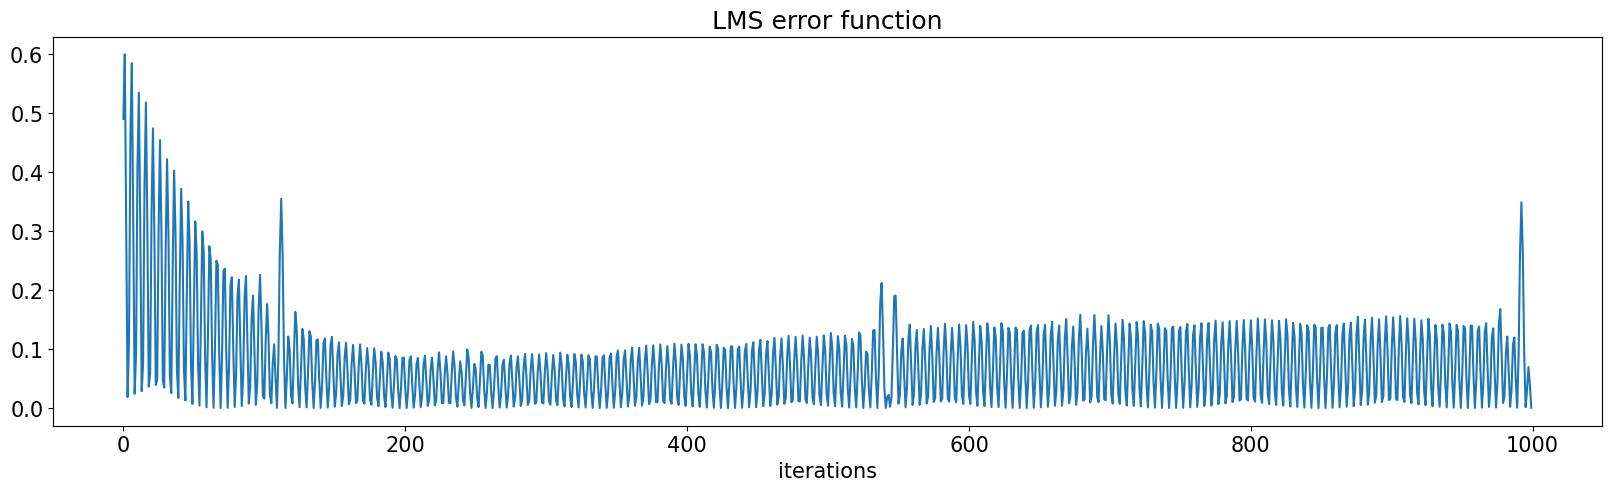

In [27]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('iterations')

ax.set_title('LMS error function')
ax.plot(lms.error[:1000]**2)

plt.show()

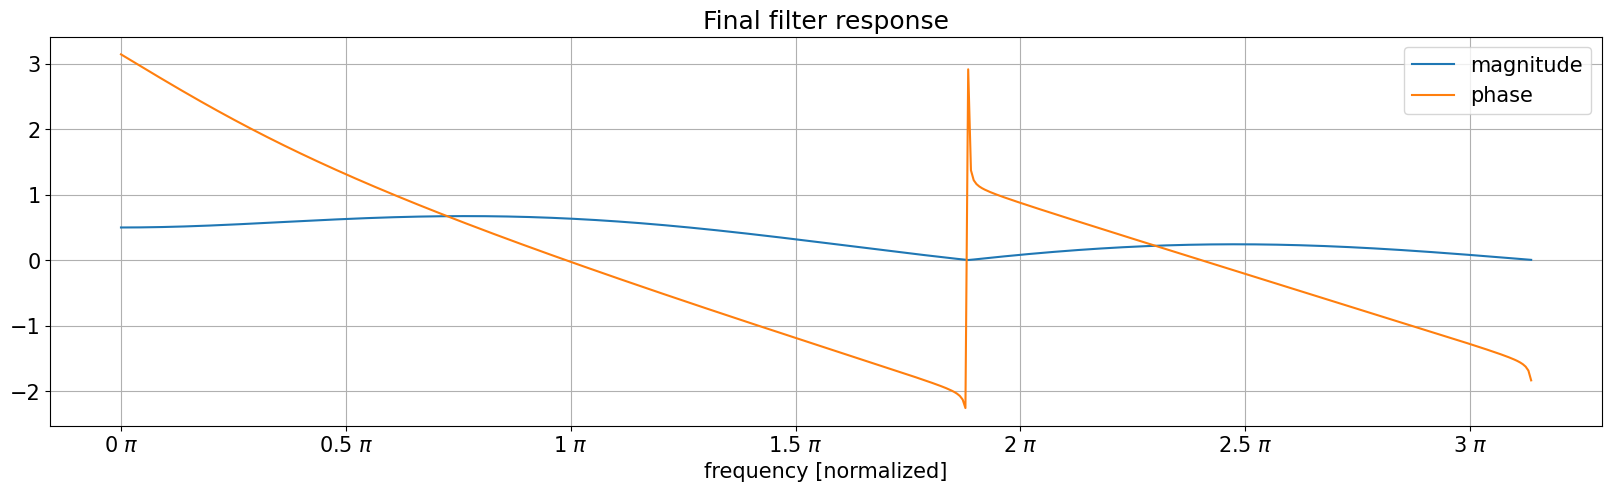

In [28]:
freq, filt_rsp = signal.freqz(weights)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('Final filter response')
ax.plot(freq, np.abs(filt_rsp), label='magnitude')
ax.plot(freq, np.angle(filt_rsp), label='phase')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()

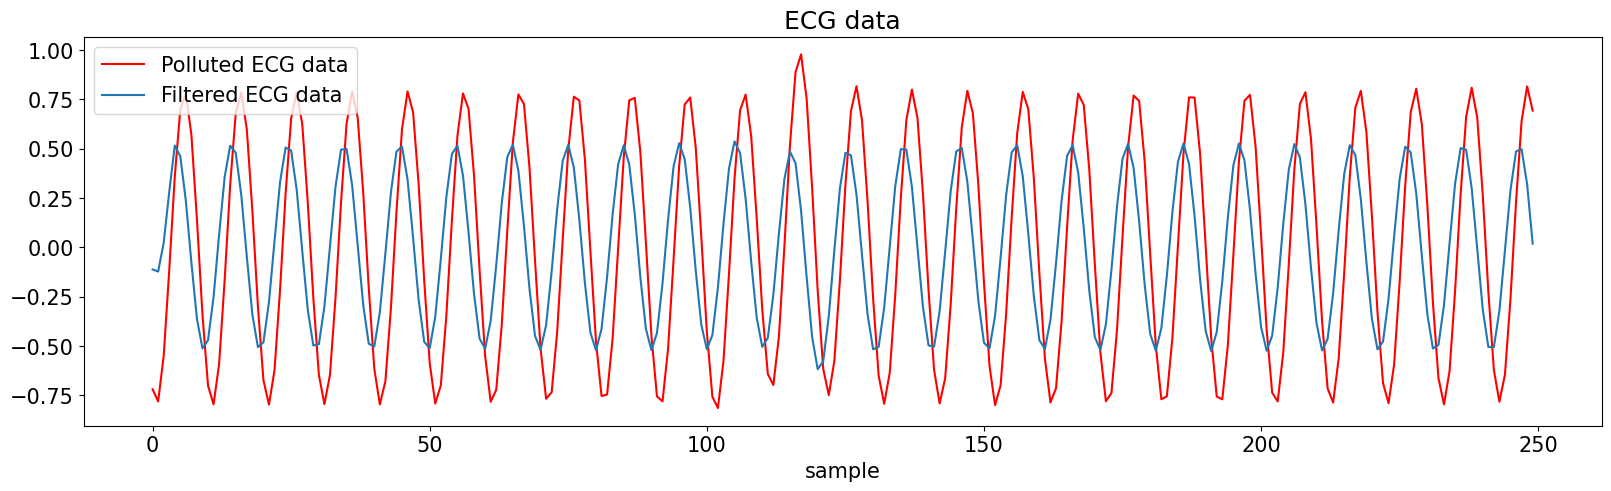

In [29]:
filtered_ecg = signal.lfilter(weights, [1], ecg_data)
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:250], 'r', label='Polluted ECG data')
ax.plot(filtered_ecg[:250], label='Filtered ECG data')

plt.legend()
plt.show()

In [30]:
_, ecg_spectrum_filt = signal.welch(filtered_ecg, fs=sample_rate,nperseg=512)

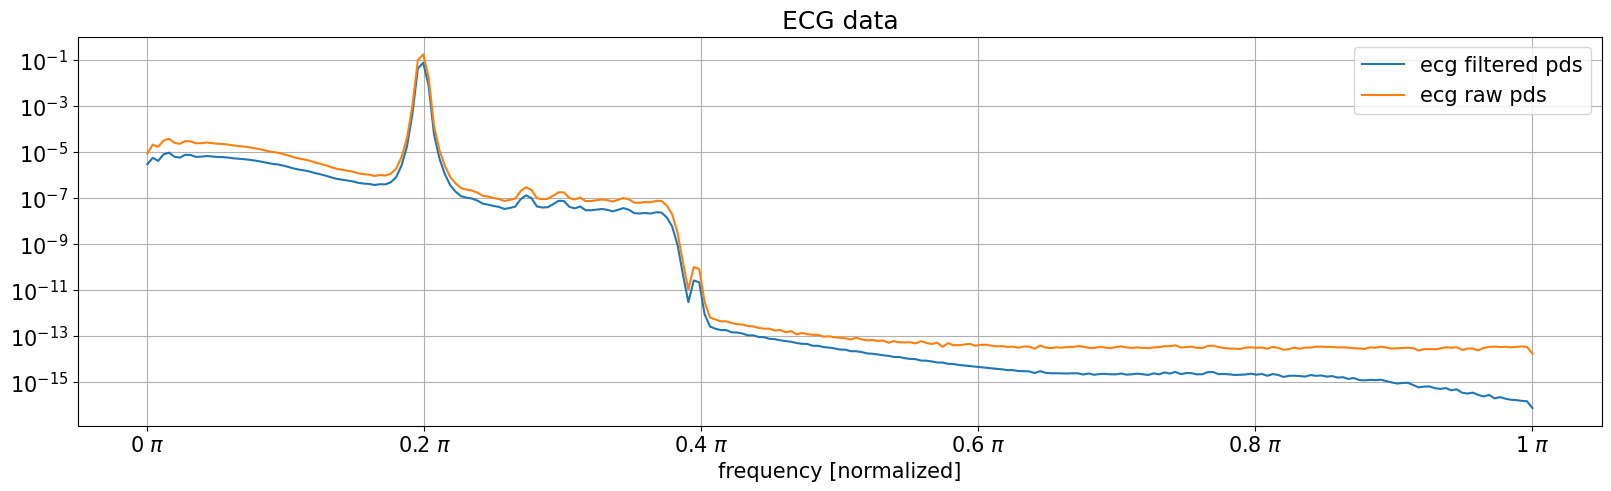

In [31]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG data')
ax.semilogy(norm_frequencies, ecg_spectrum_filt, label='ecg filtered pds')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg raw pds')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()
